# Setting & import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from tqdm.auto import tqdm
from statsmodels.tsa.seasonal import STL
from sklearn.preprocessing import LabelEncoder
import random
import os
import pickle
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

plt.rc('font',family='Malgun Gothic')
rcParams['axes.unicode_minus'] =False

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
CFG = {
    'TRAIN_WINDOW_SIZE':90, # 90일치로 학습
    'PREDICT_SIZE':30, # 30일치 예측
    'EPOCHS':2,
    'LEARNING_RATE':1.75e-3,
    'BATCH_SIZE':32,
    'SEED':7
}
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

# Data Load

## 관광지 입장 데이터

In [173]:
enter = pd.read_csv('enter_merge.csv')

In [174]:
category = pd.read_csv('2023해커톤용데이터/4. 빅데이터센터구축데이터(필수활용)/1. 제주관광공사 데이터(필수활용)/001. 가공데이터/JT_TRRSRT_ENTRN_LIST_관광지 입장 데이터/JT_TRRSRT_ENTRN_LIST_202212 - groupby_카테고리 수정.csv',encoding='cp949')

In [175]:
ct_dic = {}
for k,v in zip(category['TRRSRT_NM'], category['CL_NM']):
  ct_dic[k] = v

In [176]:
enter = enter.drop(['TEL_NO','SETLE_PRICE'],axis=1)

In [177]:
enter = enter.groupby(['CL_NM','TRRSRT_NM','ADDR','ENTRN_DE']).sum()

In [178]:
enter = enter.reset_index()

In [179]:
for k,v in ct_dic.items():
  enter.loc[enter[enter['TRRSRT_NM']==k].index,'CL_NM'] = v

In [180]:
enter = enter.groupby(['CL_NM','TRRSRT_NM','ADDR','ENTRN_DE']).sum().unstack(level=3)

In [181]:
enter1 = enter.reset_index()

In [185]:
enter2 = enter1.droplevel(level=0,axis=1)

In [193]:
enter_col = list(enter2.columns)

In [195]:
enter_col[:3] = ['CL_NM','TRRSRT_NM','ADDR']

In [196]:
enter2.columns = enter_col

In [72]:
for row in tqdm(range(len(enter2))):
  enter2.iloc[row,3:] = enter2.iloc[row,3:].fillna(int(enter2.iloc[row,3:].mean()))

  0%|          | 0/162 [00:00<?, ?it/s]

In [203]:
enter2.to_csv('enter_fin.csv',index=False)

## 공영관광지 입장 데이터

In [207]:
public = pd.DataFrame()
month_list = ['01','02','03','04','05','06','07','08','09','10','11','12']
for i in month_list:
  public = pd.concat([public,pd.read_csv(f'2023해커톤용데이터/공영관광지 입장 데이터/JT_DAY_PUBLIC_TRRSRT_ENTRN_LIST_2022{i}.csv')],axis=0)

In [224]:
cate_dict = {'감귤박물관':'문화관광','서귀포시립기당미술관':'문화관광','서귀포천문과학문화관':'문화관광','서복전시관':'문화관광',
             '소암기념관':'문화관광','이중섭미술관':'문화관광','제주돌문화공원':'문화관광','대포주상절리':'자연','만장굴':'자연',
             '모구리야영장':'휴식_힐링','비자림':'자연','산방산암벽식물지대':'자연','서귀포치유의숲':'휴식_힐링','성산일출봉':'자연',
             '용머리해안':'자연','정방폭포':'자연','천제연폭포':'자연','천지연폭포':'자연','기당미술관':'문화관광'}

In [226]:
public = public.drop(['TEL_NO','SETLE_PRICE'],axis=1)

In [228]:
public = public.groupby(['CL_NM','TRRSRT_NM','ADDR','ENTRN_DE']).sum()

In [229]:
public = public.reset_index()

In [231]:
for k,v in cate_dict.items():
  public.loc[public[public['TRRSRT_NM']==k].index,'CL_NM'] = v

In [232]:
public = public.groupby(['CL_NM','TRRSRT_NM','ADDR','ENTRN_DE']).sum().unstack(level=3)

In [233]:
public1 = public.reset_index()

In [235]:
public2 = public1.droplevel(level=0,axis=1)

In [236]:
public_col = list(public2.columns)

In [237]:
public_col[:3] = ['CL_NM','TRRSRT_NM','ADDR']

In [238]:
public2.columns = public_col

In [118]:
for row in tqdm(range(len(public2))):
  public2.iloc[row,3:] = public2.iloc[row,3:].fillna(int(public2.iloc[row,3:].mean()))

  0%|          | 0/20 [00:00<?, ?it/s]

In [239]:
public2.to_csv('public_fin.csv',index=False)

# Preprocessing

## Data Load

### Data concatenate

In [43]:
data = pd.read_csv('enter_fin.csv')

In [44]:
public = pd.read_csv('public_fin.csv')

In [45]:
for i in public['TRRSRT_NM'].unique():
  if i in data['TRRSRT_NM'].unique():
    print(i)

제주돌문화공원
성산일출봉


In [46]:
# 중복 row 삭제 -> 제주돌문화공원 및 성산일출봉은 공영관광지이므로 민영관광지 dataset에서 삭제
data = data.drop(data[(data['TRRSRT_NM']=='제주돌문화공원')|(data['TRRSRT_NM']=='성산일출봉')].index,axis=0)

In [47]:
data_fin = pd.concat([data,public],axis=0)

In [48]:
data_fin.to_csv('data_fin.csv',index=False)

### data load 시 아래 행만 수행

In [49]:
data = pd.read_csv('data_fin.csv')

## Data split

In [26]:
train_data = data.iloc[:,:-CFG['PREDICT_SIZE']]
test_data = pd.concat([data.iloc[:,:3],data.iloc[:,-CFG['PREDICT_SIZE']:]],axis=1)

NameError: name 'data' is not defined

In [51]:
test_data.to_csv('Demand_Forecasting/test_data.csv',index=False)

In [52]:
test_data = pd.read_csv('Demand_Forecasting/test_data.csv')

## 잔차 계산

In [53]:
# 시계열 분해 후 잔차 계산

def residual(data, category_column_size):
  data = data.iloc[:,category_column_size:].T.values
  residual = []
  for idx in tqdm(range(len(data.T))):
    stl = STL(data[: ,idx], period=12, robust=True).fit()
    residual.append(stl.resid)
  return np.array(residual)

residual_data = residual(train_data, 3)

  0%|          | 0/180 [00:00<?, ?it/s]

In [54]:
pd.DataFrame(residual_data).to_csv('Demand_Forecasting/residual_data.csv', index=False)

In [55]:
residual_data = pd.read_csv('Demand_Forecasting/residual_data.csv').values

## 단위 가격 계산

In [56]:
enter = pd.read_csv('enter_merge.csv')

In [57]:
enter = enter[(enter['TRRSRT_NM']!='성산일출봉')&(enter['TRRSRT_NM']!='제주돌문화공원')]

In [58]:
public = pd.DataFrame()
month_list = ['01','02','03','04','05','06','07','08','09','10','11','12']
for i in month_list:
  public = pd.concat([public,pd.read_csv(f'2023해커톤용데이터/공영관광지 입장 데이터/JT_DAY_PUBLIC_TRRSRT_ENTRN_LIST_2022{i}.csv')],axis=0)

In [59]:
enter_public = pd.concat([enter,public],axis=0)

In [60]:
enter_public = enter_public.drop(['CL_NM','ADDR','TEL_NO','ENTRN_DE'],axis=1)

In [61]:
enter_public = enter_public.groupby('TRRSRT_NM').sum().reset_index()

In [62]:
enter_public['unit_price'] = (enter_public['SETLE_PRICE']/enter_public['TOT_ENTRN_NMPR_CO']).astype('int')

In [63]:
enter_public = enter_public.drop(['TOT_ENTRN_NMPR_CO','SETLE_PRICE'],axis=1)

In [64]:
price_list=list()
for i in train_data.TRRSRT_NM:
  price_list.append(enter_public[enter_public['TRRSRT_NM']==i]['unit_price'].values[0])

In [65]:
train_data.insert(3,'UNIT_PRICE',price_list)

## Label encoding

In [66]:
lbe = LabelEncoder()
train_data['CL_NM'] = lbe.fit_transform(train_data['CL_NM'])

In [67]:
train_data['ADDR'] = lbe.fit_transform(train_data['ADDR'])

## Scaling

In [69]:
mms = MinMaxScaler()
mms.fit(np.array(train_data['UNIT_PRICE']).reshape(-1,1))

MinMaxScaler()

In [70]:
train_data['UNIT_PRICE'] = mms.transform(np.array(train_data['UNIT_PRICE']).reshape(-1,1))

In [71]:
# Data Scaling
scale_max_dict = {}
scale_min_dict = {}

for idx in tqdm(range(len(train_data))):
    maxi = np.max(train_data.iloc[idx,4:])
    mini = np.min(train_data.iloc[idx,4:])

    if maxi == mini :
        train_data.iloc[idx,4:] = 0
    else:
        train_data.iloc[idx,4:] = (train_data.iloc[idx,4:] - mini) / (maxi - mini)

    scale_max_dict[idx] = maxi
    scale_min_dict[idx] = mini

  0%|          | 0/180 [00:00<?, ?it/s]

In [72]:
# Save Min-Max of Scaling
with open('Demand_Forecasting/scale_max_dict.pkl','wb') as f:
  pickle.dump(scale_max_dict,f)

with open('Demand_Forecasting/scale_min_dict.pkl','wb') as f:
  pickle.dump(scale_min_dict,f)

In [73]:
# Load Min-Max of Scaling

with open('Demand_Forecasting/scale_max_dict.pkl','rb') as f:
  scale_max_dict = pickle.load(f)

with open('Demand_Forecasting/scale_min_dict.pkl','rb') as f:
  scale_min_dict = pickle.load(f)

In [74]:
# Save scaling data
train_data.to_csv('Demand_Forecasting/train_data_scaling.csv',index=False)

In [75]:
train_data = pd.read_csv('Demand_Forecasting/train_data_scaling.csv')

## 군집 분석

In [76]:
train_data_cls = train_data.copy()
train_data_cls = train_data_cls.drop('TRRSRT_NM',axis=1)

KElbowVisualizer(ax=<Axes: >,
                 estimator=KMeans(n_clusters=14, n_init=250, random_state=7),
                 k=(3, 15))

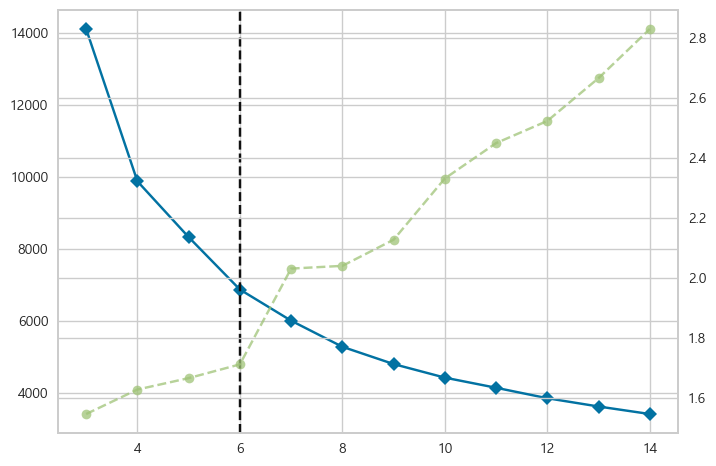

In [77]:
n_init = 250
model = KMeans(n_init=n_init, random_state=CFG['SEED'])
visualizer = KElbowVisualizer(model, k=(3,15))
visualizer.fit(train_data_cls)

In [78]:
k = 6

# 그룹 수, random_state 설정
model = KMeans(n_init=250, n_clusters = k, random_state = 10)

# 정규화된 데이터에 학습
model.fit(train_data_cls)

KMeans(n_clusters=6, n_init=250, random_state=10)

In [79]:
# 클러스터링 결과 각 데이터가 몇 번째 그룹에 속하는지 저장
cluster = model.predict(train_data_cls)

In [80]:
# 군집화 점수 0.5가 넘으면 충분
silhouette_score(train_data_cls, cluster, metric='euclidean')

0.4144484624397666

In [81]:
train_data.insert(0,'CLUSTER',cluster)

In [82]:
train_data.to_csv('Demand_Forecasting/train_data_scaling.csv',index=False)

# Modeling

## Making Dataset

In [4]:
train_data = pd.read_csv('Demand_Forecasting/train_data_scaling.csv')
test_data = pd.read_csv('Demand_Forecasting/test_data.csv')
with open('Demand_Forecasting/scale_max_dict.pkl','rb') as f:
  scale_max_dict = pickle.load(f)

with open('Demand_Forecasting/scale_min_dict.pkl','rb') as f:
  scale_min_dict = pickle.load(f)

residual_data = pd.read_csv('Demand_Forecasting/residual_data.csv').values

In [5]:
# 관광지명 제거
train_data = train_data.drop('TRRSRT_NM',axis=1)

In [6]:
class CustomDataset(Dataset):
    def __init__(self, data, residual, encode_cnt, train_size=CFG['TRAIN_WINDOW_SIZE'], predict_size=CFG['PREDICT_SIZE'], is_inference=False):
        self.data = data.values # convert DataFrame to numpy array
        self.residual = residual
        self.encode_cnt = encode_cnt
        self.train_size = train_size
        self.predict_size = predict_size
        self.window_size = self.train_size + self.predict_size
        self.is_inference = is_inference

    def __len__(self):
        if self.is_inference:
            return len(self.data)
        else:
            return self.data.shape[0] * (self.data.shape[1] - self.window_size - (self.encode_cnt-1)) # encode 개수 - 1

    def __getitem__(self, idx): # class의 index에 접근할 때 자동으로 호출되는 메소드
        if self.is_inference:
            # 추론 시
            encode_info = self.data[idx, :self.encode_cnt]
            window = self.data[idx, -self.train_size:]            
            residual_window = self.residual[idx, -self.train_size:]
            input_data = np.column_stack((np.tile(encode_info, (self.train_size, 1)), window, residual_window))
            return input_data
        else:
            # 학습 시
            row = idx // (self.data.shape[1] - self.window_size - (self.encode_cnt-1)) # encode 개수 - 1
            col = idx % (self.data.shape[1] - self.window_size - (self.encode_cnt-1)) #encode 개수 - 1
            encode_info = self.data[row, :self.encode_cnt]
            enter_data = self.data[row, self.encode_cnt:]
            residual_data = self.residual[row, :]
            window = enter_data[col : col + self.window_size]
            residual_window = residual_data[col : col + self.window_size]
            input_data = np.column_stack((np.tile(encode_info, (self.train_size, 1)), window[:self.train_size], residual_window[:self.train_size]))
            target_data = window[self.train_size:]
            return input_data, target_data

In [7]:
# CustomDataset 인스턴스 생성
dataset = CustomDataset(train_data, residual_data, 4)

# 전체 데이터셋의 크기
total_size = len(dataset)

# 분리할 데이터셋의 크기 계산
train_size = int(total_size * 0.8)
val_size = total_size - train_size

# random_split 함수를 사용해 데이터셋 분리
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoader 인스턴스 생성
train_loader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False)

In [8]:
class BaseModel(nn.Module): # 단위가격 feature 생성 >> input_size = dataset[0][0].shape[1]
    def __init__(self, input_size=dataset[0][0].shape[1], num_layers=1, hidden_size=128, output_size=CFG['PREDICT_SIZE'], bidirectional = True):
        super(BaseModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional = bidirectional)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size//2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden_size//2, output_size)
        )

        self.actv = nn.ReLU()

    def forward(self, x):
        # x shape: (B, TRAIN_WINDOW_SIZE, 5)
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size, x.device)

        # LSTM layer
        lstm_out, hidden = self.lstm(x, hidden)

        # Only use the last output sequence
        last_output = lstm_out[:, -1, :]

        # Fully connected layer
        output = self.actv(self.fc(last_output))

        return output.squeeze(1)

    def init_hidden(self, batch_size, device):
        # Initialize hidden state and cell state
        return (torch.zeros(self.num_layers * 2, batch_size, self.hidden_size, device=device),
                torch.zeros(self.num_layers * 2, batch_size, self.hidden_size, device=device))

In [9]:
class EarlyStopping(object):
    def __init__(self, patience=2, save_path="model.pth"):
        self._min_loss = np.inf
        self._patience = patience
        self._path = save_path
        self.__counter = 0

    def should_stop(self, model, loss):
        if loss < self._min_loss:
            self._min_loss = loss
            self.__counter = 0
            torch.save(model.state_dict(), self._path)
        elif loss > self._min_loss:
            self.__counter += 1
            if self.__counter >= self._patience:
                return True
        return False

    def load(self, model):
        model.load_state_dict(torch.load(self._path))
        return model

    @property
    def counter(self):
        return self.__counter

In [10]:
def train(model, optimizer, train_loader, val_loader, device):
    model.to(device)
    criterion = nn.MSELoss().to(device)
    best_loss = 9999999
    best_model = None
    early_stopper = EarlyStopping(patience=3)

    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        train_mae = []
        for X, Y in tqdm(iter(train_loader)):
            X = X.float().to(device)
            Y = Y.float().to(device)

            optimizer.zero_grad()

            output = model(X)
            loss = criterion(output, Y)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        val_loss = validation(model, val_loader, criterion, device)
        print(f'Epoch : [{epoch}] Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}]')

        if early_stopper.should_stop(model, val_loss):
            print(f"EarlyStopping: [Epoch: {epoch - early_stopper.counter}]")
            break

        if best_loss > val_loss:
            best_loss = val_loss
            best_model = model
            print('Model Saved')
    return best_model

In [11]:
def validation(model, val_loader, criterion, device):
    model.eval()
    val_loss = []

    with torch.no_grad():
        for X, Y in tqdm(iter(val_loader)):
            X = X.float().to(device)
            Y = Y.float().to(device)

            output = model(X)
            loss = criterion(output, Y)

            val_loss.append(loss.item())
    return np.mean(val_loss)

In [12]:
model = BaseModel()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
infer_model = train(model, optimizer, train_loader, val_loader, device)

  0%|          | 0/972 [00:00<?, ?it/s]

  0%|          | 0/243 [00:00<?, ?it/s]

Epoch : [1] Train Loss : [0.02581] Val Loss : [0.01640]
Model Saved


  0%|          | 0/972 [00:00<?, ?it/s]

  0%|          | 0/243 [00:00<?, ?it/s]

Epoch : [2] Train Loss : [0.01825] Val Loss : [0.01568]
Model Saved


In [27]:
PATH = 'Demand_Forecasting/'

torch.save(infer_model, PATH + 'model.pt')  # 전체 모델 저장
torch.save(infer_model.state_dict(), PATH + 'model_state_dict.pt')  # 모델 객체의 state_dict 저장
torch.save({
    'model': infer_model.state_dict(),
    'optimizer': optimizer.state_dict()
}, PATH + 'all.tar')  # 여러 가지 값 저장, 학습 중 진행 상황 저장을 위해 epoch, loss 값 등 일반 scalar값 저장 가능

In [28]:
test_dataset = CustomDataset(train_data, residual_data, 4, is_inference=True)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False)

In [29]:
def inference(model, test_loader, device):
    predictions = []

    with torch.no_grad():
        for X in tqdm(iter(test_loader)):
            X = X.float().to(device)

            output = model(X)

            # 모델 출력인 output을 CPU로 이동하고 numpy 배열로 변환
            output = output.cpu().numpy()

            predictions.extend(output)

    return np.array(predictions)

In [30]:
pred = inference(infer_model, test_loader, device)

  0%|          | 0/6 [00:00<?, ?it/s]

In [31]:
# 추론 결과를 inverse scaling
for idx in range(len(pred)):
    pred[idx, :] = pred[idx, :] * (scale_max_dict[idx] - scale_min_dict[idx]) + scale_min_dict[idx]

# 결과 후처리
pred = np.round(pred, 0).astype(int)

In [34]:
pred_data = pd.concat([test_data.iloc[:,:3],pd.DataFrame(pred)],axis=1)

In [35]:
pred_data.columns = test_data.columns

In [36]:
pred_data.to_csv('Demand_Forecasting/predict_0923AM1100.csv',index=False)

In [37]:
# 데이터 확인할 row 설정
check_name = '성산일출봉'
row_check = pred_data[pred_data['TRRSRT_NM']==check_name].index
pred_check = pred_data.iloc[row_check,3:]
test_check = test_data.iloc[row_check,3:]

In [38]:
print(mean_squared_error(test_check, pred_check))
print(mean_absolute_error(test_check, pred_check))
print(mean_absolute_percentage_error(test_check, pred_check))

1282425.6333333333
815.0333333333333
0.48914117910349636


In [39]:
pd.concat([test_check, pred_check],axis=0)

,20221202,20221203,20221204,20221205,20221206,20221207,20221208,20221209,20221210,20221211,...,20221222,20221223,20221224,20221225,20221226,20221227,20221228,20221229,20221230,20221231
172,2108.0,1462.0,2113.0,2415.0,1949.0,1893.0,1899.0,2171.0,2471.0,2241.0,...,485.0,2415.0,309.0,1987.0,2392.0,2724.0,2582.0,2639.0,4623.0,5356.0
172,1609.0,1548.0,1540.0,1651.0,1630.0,1594.0,1620.0,1600.0,1590.0,1622.0,...,1586.0,1592.0,1590.0,1582.0,1636.0,1638.0,1578.0,1527.0,1586.0,1556.0
